In [1]:
!pip install tsfresh


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 7.6 MB/s eta 0:00:00


In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import quarter_plot, month_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.examples.robot_execution_failures import load_robot_execution_failures
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction.settings import from_columns

import warnings
warnings.filterwarnings('ignore')

In [39]:
df = yf.download('AMZN', start='2019-06-01', end='2023-06-30')
df.shape


[*********************100%%**********************]  1 of 1 completed


(1027, 6)

In [40]:
data = df.copy()

# Exploratory Data Analysis

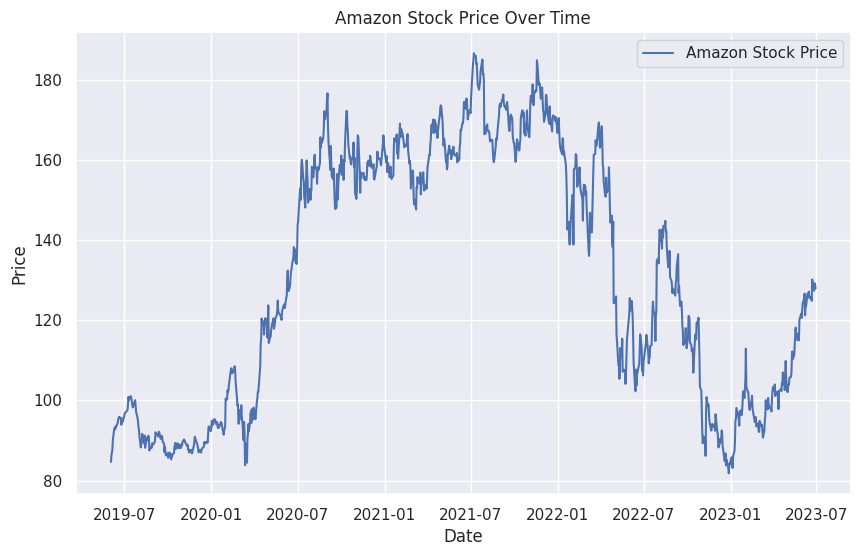

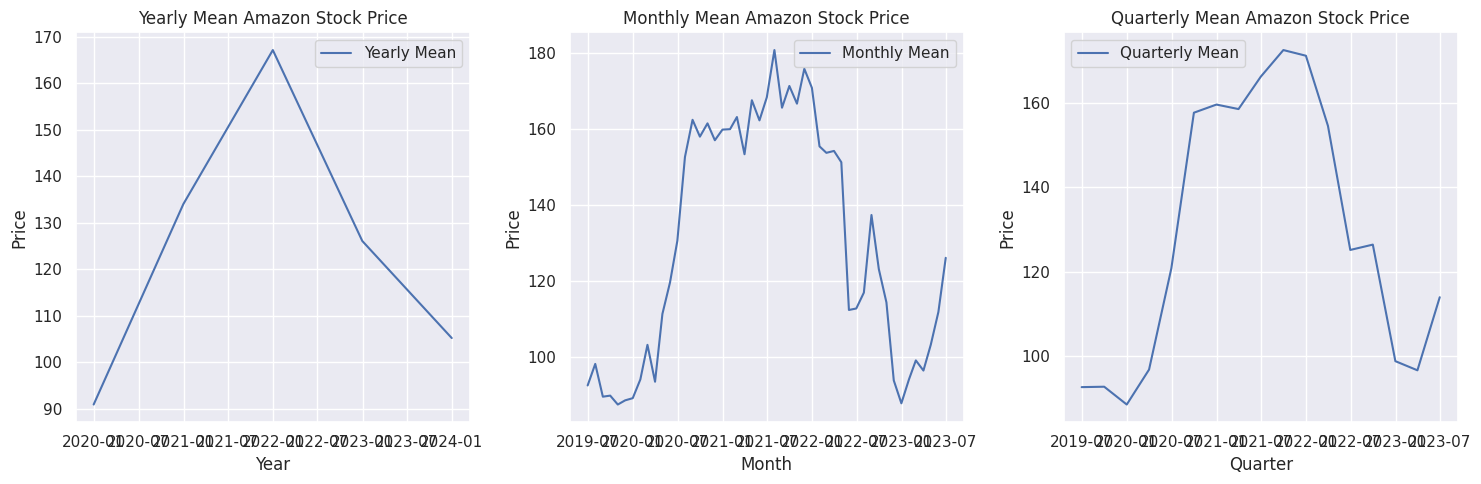

Stationarity Test - Original Data:
ADF Test Results:
ADF Statistic: -1.8541571910219496
p-value: 0.35392454356580166
Critical Values: {'1%': -3.4367396063176874, '5%': -2.8643611157329905, '10%': -2.5682720836420705}

Stationarity Test - Differenced Data:
ADF Test Results:
ADF Statistic: -32.84421951560837
p-value: 0.0
Critical Values: {'1%': -3.43674585579594, '5%': -2.8643638720413227, '10%': -2.5682735516954196}

Statistical Analysis:
Mean Price: 130.56276867800585
Standard Deviation: 31.594161045555527


In [41]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Amazon Stock Price')
plt.title('Amazon Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

data_yearly = data['Close'].resample('Y').mean()
data_monthly = data['Close'].resample('M').mean()
data_quarterly = data['Close'].resample('Q').mean()

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(data_yearly, label='Yearly Mean')
plt.title('Yearly Mean Amazon Stock Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()

plt.subplot(132)
plt.plot(data_monthly, label='Monthly Mean')
plt.title('Monthly Mean Amazon Stock Price')
plt.xlabel('Month')
plt.ylabel('Price')
plt.legend()

plt.subplot(133)
plt.plot(data_quarterly, label='Quarterly Mean')
plt.title('Quarterly Mean Amazon Stock Price')
plt.xlabel('Quarter')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print("ADF Test Results:")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')

print("Stationarity Test - Original Data:")
adf_test(data['Close'])

data_diff = data['Close'].diff().dropna()
print("\nStationarity Test - Differenced Data:")
adf_test(data_diff)

mean_price = data['Close'].mean()
std_dev = data['Close'].std()

print("\nStatistical Analysis:")
print(f'Mean Price: {mean_price}')
print(f'Standard Deviation: {std_dev}')

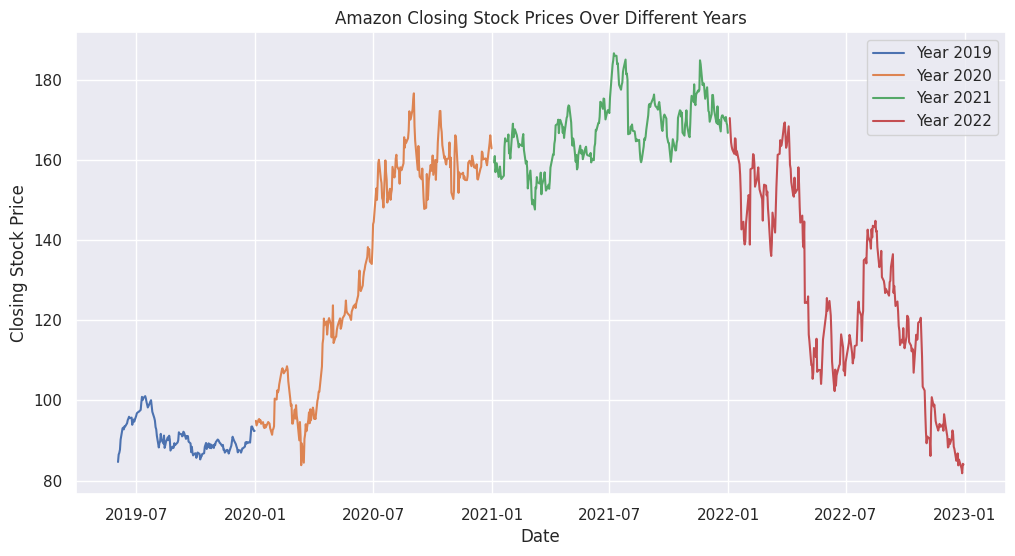

In [42]:
selected_years = [2019, 2020, 2021, 2022]
filtered_data = data[data.index.year.isin(selected_years)]

plt.figure(figsize=(12, 6))
for year in selected_years:
    year_data = filtered_data[filtered_data.index.year == year]
    sns.lineplot(x=year_data.index, y=year_data['Close'], label=f'Year {year}')

plt.title('Amazon Closing Stock Prices Over Different Years')
plt.xlabel('Date')
plt.ylabel('Closing Stock Price')
plt.legend()
plt.show()


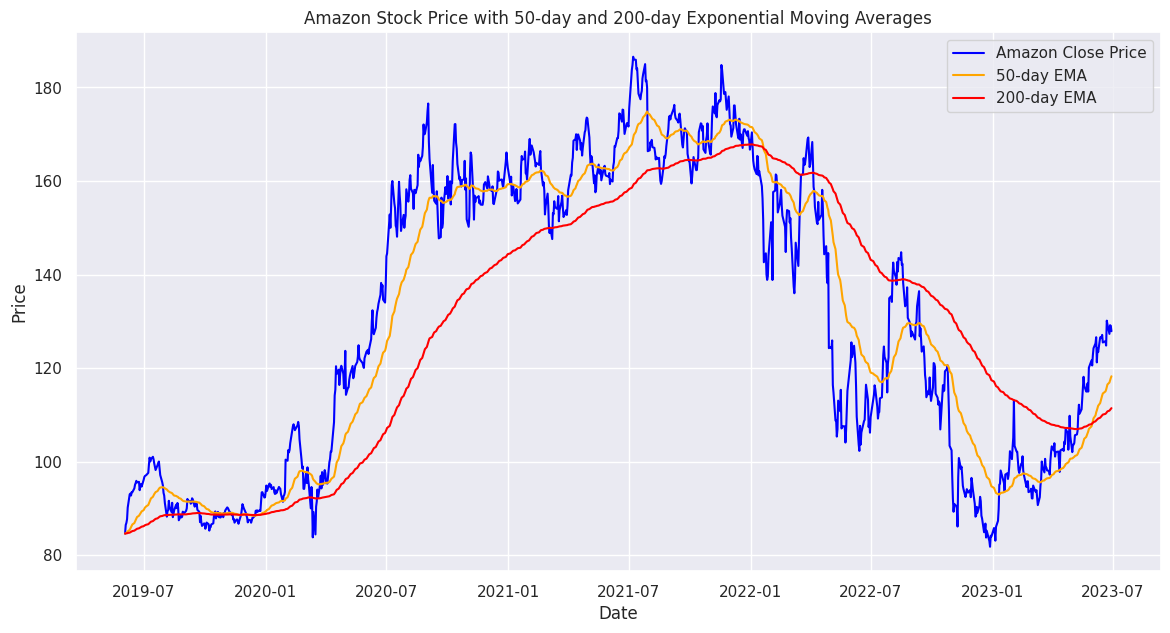

In [43]:
ema_50 = data['Close'].ewm(span=50, adjust=False).mean()

ema_200 = data['Close'].ewm(span=200, adjust=False).mean()

ema_df = pd.DataFrame({'Close': data['Close'], 'EMA_50': ema_50, 'EMA_200': ema_200})

plt.figure(figsize=(14, 7))
plt.plot(ema_df.index, ema_df['Close'], label='Amazon Close Price', color='blue')
plt.plot(ema_df.index, ema_df['EMA_50'], label='50-day EMA', color='orange')
plt.plot(ema_df.index, ema_df['EMA_200'], label='200-day EMA', color='red')
plt.title('Amazon Stock Price with 50-day and 200-day Exponential Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


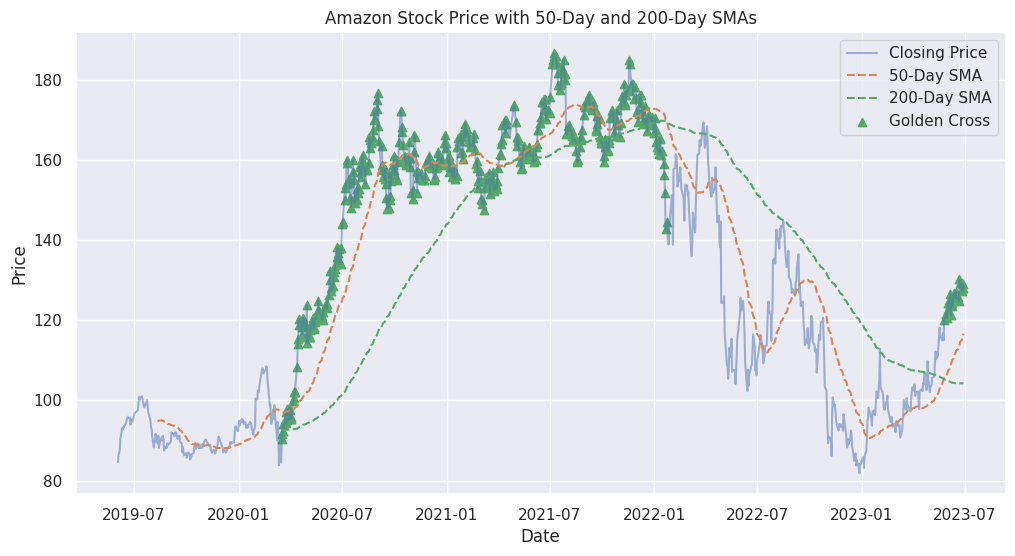

In [44]:
data_plot = data.copy()

data_plot['50-Day SMA'] = data_plot['Close'].rolling(window=50).mean()
data_plot['200-Day SMA'] = data_plot['Close'].rolling(window=200).mean()
data_plot['Golden Cross'] = 0
data_plot.loc[data_plot['50-Day SMA'] > data_plot['200-Day SMA'], 'Golden Cross'] = 1


plt.figure(figsize=(12, 6))
plt.plot(data_plot.index, data_plot['Close'], label='Closing Price', alpha=0.5)
plt.plot(data_plot.index, data_plot['50-Day SMA'], label='50-Day SMA', linestyle='--')
plt.plot(data_plot.index, data_plot['200-Day SMA'], label='200-Day SMA', linestyle='--')
plt.title('Amazon Stock Price with 50-Day and 200-Day SMAs')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()


golden_cross_points = data_plot[data_plot['Golden Cross'] == 1]
plt.scatter(golden_cross_points.index, golden_cross_points['Close'], marker='^', color='g', label='Golden Cross')

plt.legend()
plt.grid(True)
plt.show()

In [45]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1.027000e+03
mean,130.615270,132.261759,128.850911,130.562769,130.562769,7.672288e+07
std,31.693435,31.942766,31.341655,31.594161,31.594161,3.329591e+07
min,82.075500,83.480003,81.301498,81.820000,81.820000,1.762600e+07
25%,97.895000,99.357498,96.406250,98.080002,98.080002,5.499305e+07
50%,127.379997,129.259995,125.300003,127.110001,127.110001,6.695890e+07
75%,160.725746,162.545746,159.034752,161.027000,161.027000,8.839000e+07
max,187.199997,188.654007,184.839493,186.570496,186.570496,3.113460e+08


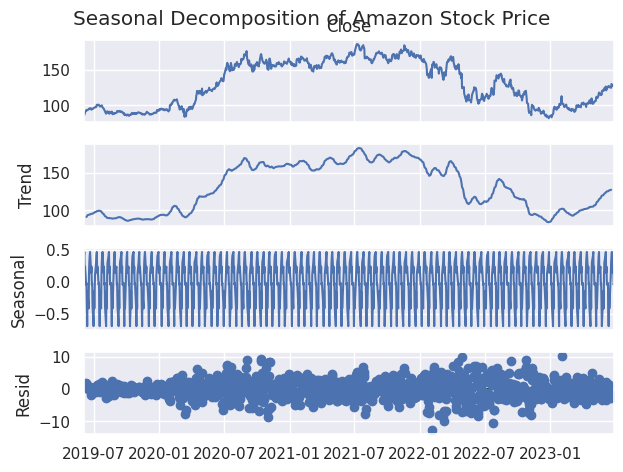

In [46]:
result = seasonal_decompose(data['Close'], model='additive', period=12)
result.plot()
plt.suptitle('Seasonal Decomposition of Amazon Stock Price')
plt.show()

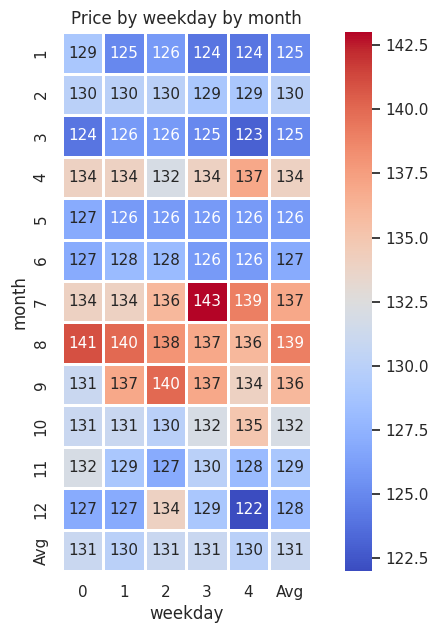

In [47]:
data["year"] = data.index.year
data["month"] = data.index.month
data["weekday"] = data.index.dayofweek

piv = pd.pivot_table(   data,
                        values='Close',
                        index="month",
                        columns="weekday",
                        aggfunc="mean",
                        margins=True, margins_name="Avg",
                        fill_value=0)

plt.figure(figsize = (9,7))
sns.set(font_scale=1)
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap="coolwarm", fmt = ".0f", annot_kws = {"size": 11})
plt.title("Price by weekday by month")
plt.show()

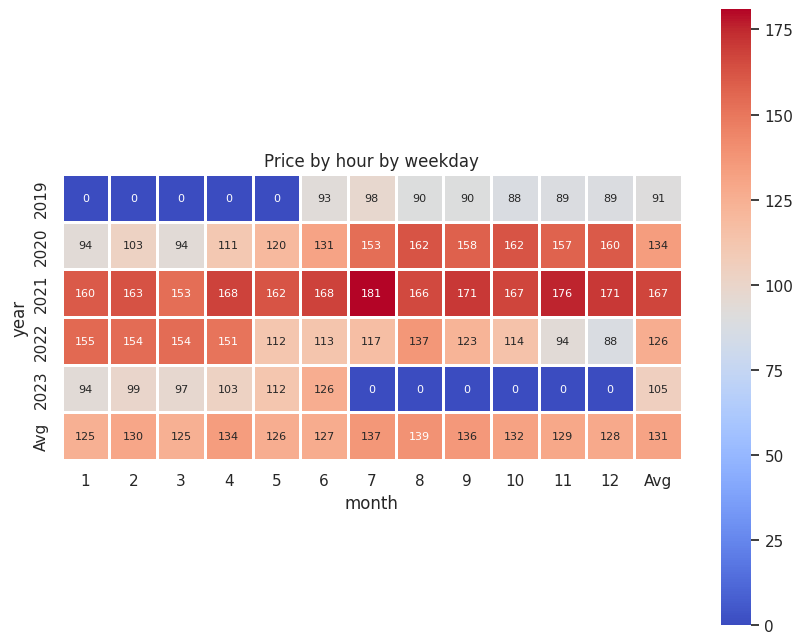

In [48]:
piv = pd.pivot_table(   data,
                        values='Close',
                        index="year",
                        columns="month",
                        aggfunc="mean",
                        margins=True, margins_name="Avg",
                        fill_value=0)

plt.figure(figsize = (10,8))
sns.set(font_scale=1)
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap="coolwarm", fmt = ".0f", annot_kws = {"size": 8})
plt.title("Price by hour by weekday")
plt.show()

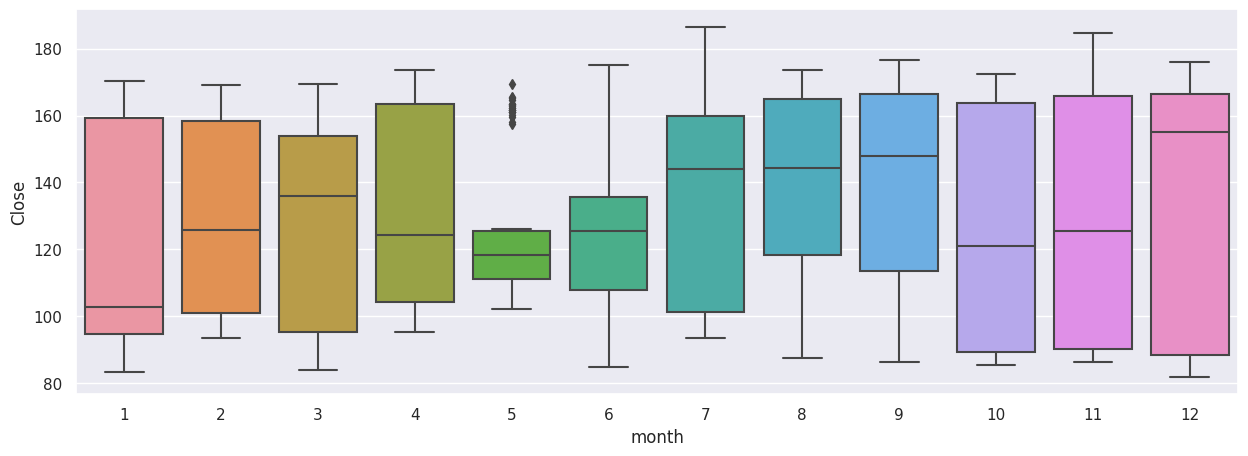

In [49]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data, x='month', y='Close')
plt.show();

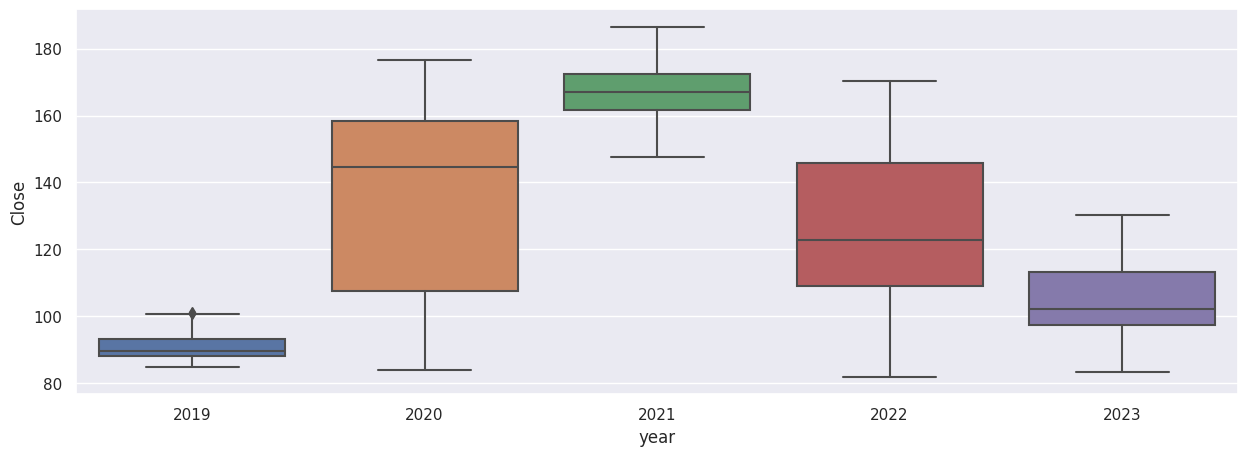

In [50]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data, x='year', y='Close')
plt.show();

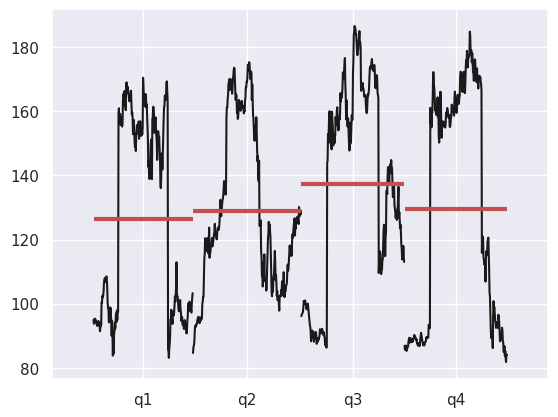

In [51]:
dta = data[['Close']]
dta.index = dta.index.to_period('Q')

quarter_plot(dta);

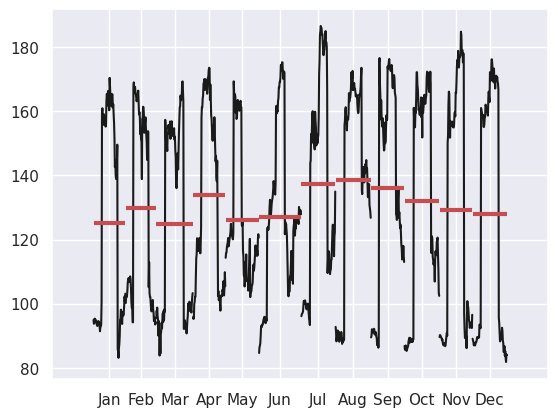

In [52]:
dta = data[['Close']]
dta.index = dta.index.to_period('M')

month_plot(dta);

# MODELS testing

In [53]:
df_melted = data[['Close']]
df_melted["date"] = df_melted.index
df_melted["Symbols"] = "AMZN"

df_melted.head()

,Close,date,Symbols
Date,,,
2019-06-03,84.634499,2019-06-03,AMZN
2019-06-04,86.477997,2019-06-04,AMZN
2019-06-05,86.925003,2019-06-05,AMZN
2019-06-06,87.718002,2019-06-06,AMZN
2019-06-07,90.201500,2019-06-07,AMZN


In [54]:
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="date",
                             max_timeshift=20, min_timeshift=5)

Rolling: 100%|██████████| 1027/1027 [00:02<00:00, 472.61it/s]


In [55]:
df_rolled[df_rolled["id"] == ("AMZN", pd.to_datetime("2020-07-14"))]

,Close,date,Symbols,id
5676,128.634003,2020-06-15,AMZN,"(AMZN, 2020-07-14 00:00:00)"
5677,130.763504,2020-06-16,AMZN,"(AMZN, 2020-07-14 00:00:00)"
5678,132.048996,2020-06-17,AMZN,"(AMZN, 2020-07-14 00:00:00)"
5679,132.699005,2020-06-18,AMZN,"(AMZN, 2020-07-14 00:00:00)"
5680,133.750504,2020-06-19,AMZN,"(AMZN, 2020-07-14 00:00:00)"
5681,135.690994,2020-06-22,AMZN,"(AMZN, 2020-07-14 00:00:00)"
5682,138.220505,2020-06-23,AMZN,"(AMZN, 2020-07-14 00:00:00)"
5683,136.720001,2020-06-24,AMZN,"(AMZN, 2020-07-14 00:00:00)"
5684,137.729004,2020-06-25,AMZN,"(AMZN, 2020-07-14 00:00:00)"
5685,134.643494,2020-06-26,AMZN,"(AMZN, 2020-07-14 00:00:00)"


In [56]:
print(len(df_melted))
print(df_rolled["id"].nunique())
df_rolled.groupby("id").size().agg([np.min, np.max])

1027
1022


amin     6
amax    21
dtype: int64

In [57]:
X = extract_features(df_rolled.drop("Symbols", axis=1),
                     column_id="id", column_sort="date", column_value="Close",
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 1022/1022 [00:54<00:00, 18.92it/s]


In [58]:
print(X.shape)
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X.head()

(1022, 783)


,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,Close__median,...,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
2019-06-10,1.0,0.0,0.0,0.0,528.988503,46683.017287,1.679401,1.679401,0.123313,87.321503,...,0.562335,1.039721,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,2.708050,0.0,135.474001
2019-06-11,1.0,0.0,0.0,0.0,622.173500,55366.461057,1.425083,1.425083,-0.169000,87.718002,...,0.562335,1.039721,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,135.474001
2019-06-12,1.0,0.0,0.0,0.0,714.939499,63971.991598,1.281357,1.161643,-0.188541,88.959751,...,0.950271,1.332179,1.609438,0.450561,0.500402,0.562335,0.636514,0.693147,0.0,90.043571
2019-06-13,1.0,0.0,0.0,0.0,808.454498,72717.046709,1.214812,1.110063,-0.078178,90.201500,...,0.950271,1.332179,1.609438,0.796312,0.867563,0.950271,1.039721,1.098612,0.0,91.048858
2019-06-14,1.0,0.0,0.0,0.0,901.937996,81456.211036,1.083333,0.983222,-0.117188,91.483749,...,0.867563,1.242453,1.560710,1.073543,1.153742,1.242453,1.332179,1.386294,0.0,91.985785


In [59]:
X.loc['2020-07-14']

Close__variance_larger_than_standard_deviation                 1.000000
Close__has_duplicate_max                                       0.000000
Close__has_duplicate_min                                       0.000000
Close__has_duplicate                                           0.000000
Close__sum_values                                           2986.754990
                                                               ...     
Close__permutation_entropy__dimension_5__tau_1                 2.343933
Close__permutation_entropy__dimension_6__tau_1                 2.599302
Close__permutation_entropy__dimension_7__tau_1                 2.708050
Close__query_similarity_count__query_None__threshold_0.0       0.000000
Close__mean_n_absolute_max__number_of_maxima_7               155.063570
Name: 2020-07-14 00:00:00, Length: 783, dtype: float64

In [60]:
y = df_melted.set_index("date").sort_index()['Close'].shift(-1)
y

date
2019-06-03     86.477997
2019-06-04     86.925003
2019-06-05     87.718002
2019-06-06     90.201500
2019-06-07     93.031502
                 ...    
2023-06-23    127.330002
2023-06-26    129.179993
2023-06-27    129.039993
2023-06-28    127.900002
2023-06-29           NaN
Name: Close, Length: 1027, dtype: float64

In [61]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

In [62]:
X_train = X[:"2023-05-31"]
X_test = X["2023-06-01":"2023-06-28"]

y_train = y[:"2023-05-31"]
y_test = y["2023-06-01":"2023-06-28"]



In [63]:
X_train_selected = select_features(X_train, y_train)

X_test_selected = X_test[X_train_selected.columns]

X_train_selected.shape

(1002, 253)

In [64]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_selected, y_train)
lr_pred = pd.Series(lr_model.predict(X_test_selected), index=X_test_selected.index)

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_selected, y_train)
rf_pred = pd.Series(rf_model.predict(X_test_selected), index=X_test_selected.index)

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_selected, y_train)
gb_pred = pd.Series(gb_model.predict(X_test_selected), index=X_test_selected.index)

# Evaluate models using Mean Squared Error
mse_lr = mean_squared_error(y_test, lr_pred)
mse_rf = mean_squared_error(y_test, rf_pred)
mse_gb = mean_squared_error(y_test, gb_pred)

print("Mean Squared Error (Linear Regression):", mse_lr)
print("Mean Squared Error (Random Forest Regressor):", mse_rf)
print("Mean Squared Error (Gradient Boosting Regressor):", mse_gb)

Mean Squared Error (Linear Regression): 8.958247216160144
Mean Squared Error (Random Forest Regressor): 9.287882385671004
Mean Squared Error (Gradient Boosting Regressor): 8.401147243129916


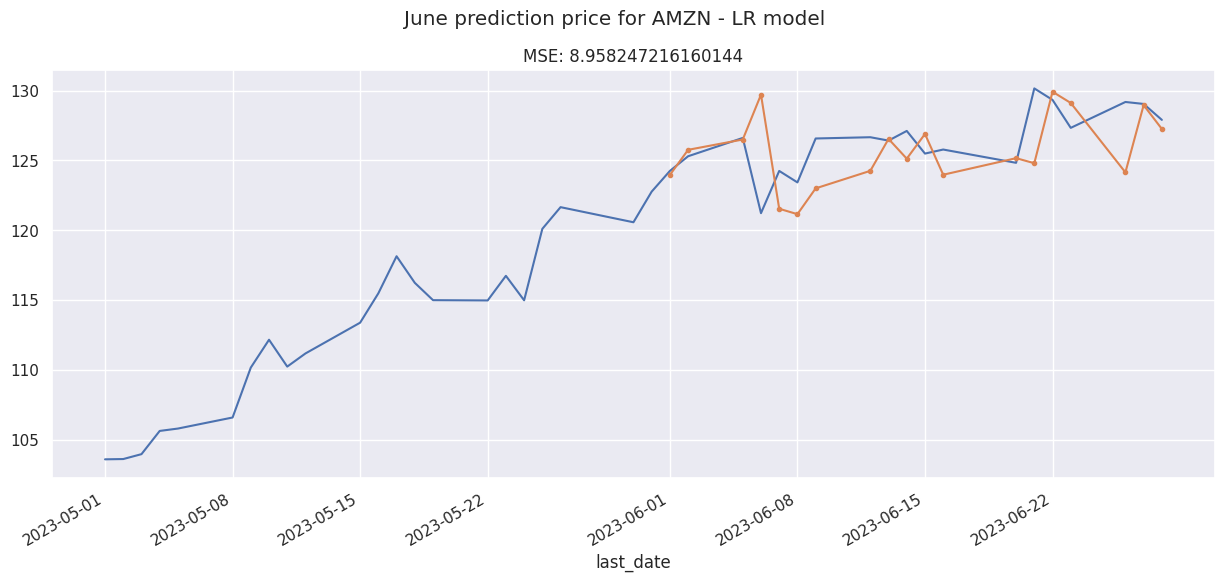

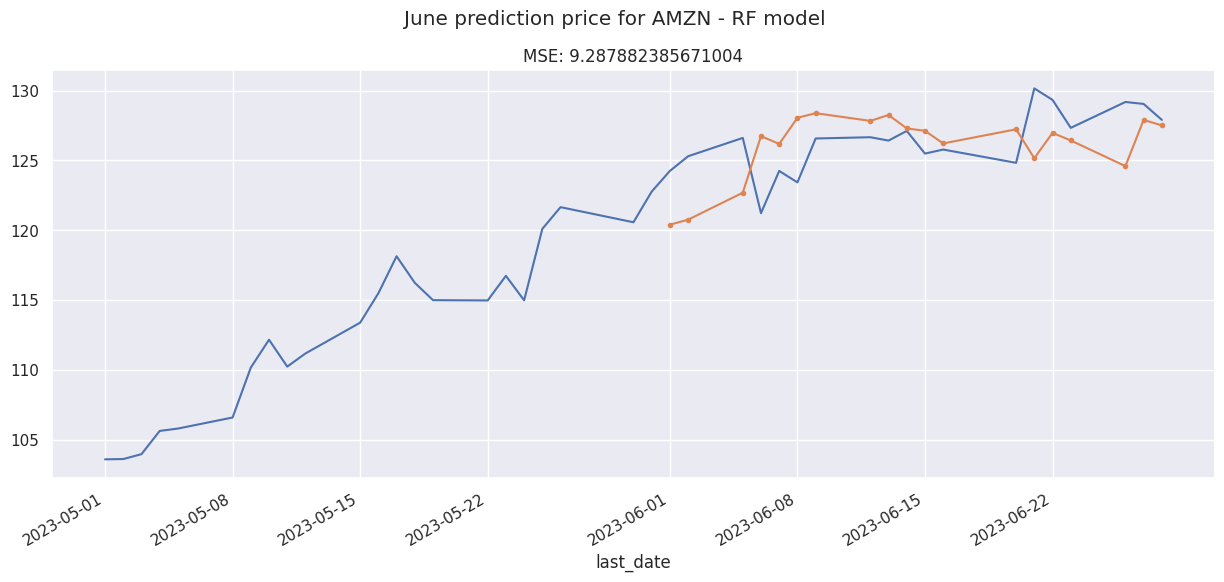

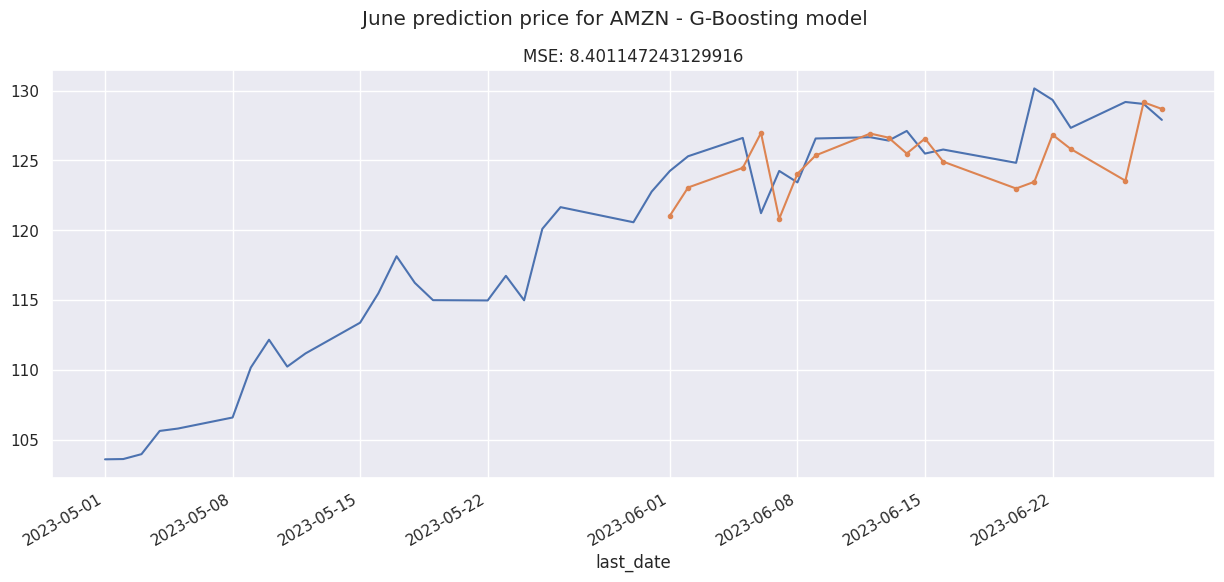

In [65]:
models_dict = {'LR': [lr_pred,mse_lr], 'RF': [rf_pred,mse_rf], 'G-Boosting': [gb_pred,mse_gb]}

for model in models_dict.items():
    plt.figure(figsize=(15, 6))

    y["2023-05-01":].plot(ax=plt.gca())
    model[1][0].plot(ax=plt.gca(), legend=None, marker=".")
    plt.suptitle(f'June prediction price for AMZN - {model[0]} model')
    plt.title(f'MSE: {model[1][1]}')
    plt.plot();

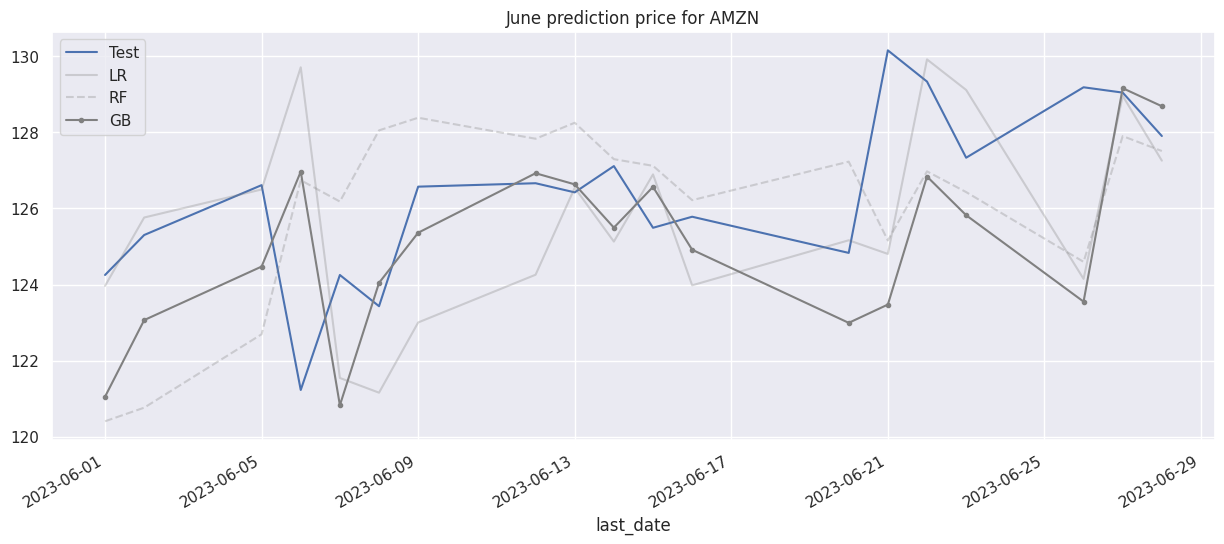

In [66]:
plt.figure(figsize=(15, 6))

y["2023-06-01":].plot(ax=plt.gca(), label='Test')
lr_pred.plot(ax=plt.gca(), legend=None, ls="-", color='grey', label='LR', alpha=0.3)
rf_pred.plot(ax=plt.gca(), legend=None, ls="--", color='grey', label='RF', alpha=0.3)
gb_pred.plot(ax=plt.gca(), legend=None, marker=".", color='grey', label='GB')
plt.title(f'June prediction price for AMZN')
plt.legend()
plt.plot();